In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.model_selection import cross_val_score, train_test_split, ParameterGrid, LeaveOneOut
from sklearn import preprocessing, linear_model, ensemble, svm, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score, confusion_matrix

from IPython.display import Image, display

import pydotplus
import graphviz
import time

In [2]:
df = pd.read_csv('C:/Users/Val/Desktop/Thinkful/Bootcamp/Unit 2 - Supervised Learning/Lesson 3 - Evaluation/heart.csv')

In [3]:
df['old'] = np.where(df['age']>=55, 1, 0)
df['young'] = np.where(df['age']<=40, 1, 0)
df['high_col'] = np.where(df.chol >= 250, 1, 0)
df['high_bps'] = np.where(df.trestbps >= 130, 1, 0)
df['young_high_bps'] = np.where((df.trestbps <= 140) & (df.age <= 45), 1, 0)
df['chest_pain'] = np.where(df.cp >= 1, 1, 0)
df.sex = np.where(df.sex == 1, 'male', 'female')
df['sex_slope'] = df['sex'] + '_' + df['slope'].astype(str)
df = pd.concat([df, pd.get_dummies(df.sex_slope, drop_first=True)], axis=1)

In [95]:
df.describe()

,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,old,young,high_col,high_bps,young_high_bps,chest_pain,female_1,female_2,male_0,male_1,male_2
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554,0.524752,0.062706,0.425743,0.554455,0.198020,0.528053,0.148515,0.151815,0.052805,0.313531,0.316832
std,9.082101,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835,0.500213,0.242835,0.495273,0.497848,0.399166,0.500038,0.356198,0.359435,0.224015,0.464696,0.466011
min,29.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,55.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,77.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [94]:
pd.options.display.max_columns = None
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,old,young,high_col,high_bps,young_high_bps,chest_pain,sex_slope,female_1,female_2,male_0,male_1,male_2
0,63,male,3,145,233,1,0,150,0,2.3,0,0,1,1,1,0,0,1,0,1,male_0,0,0,1,0,0
1,37,male,2,130,250,0,1,187,0,3.5,0,0,2,1,0,1,1,1,1,1,male_0,0,0,1,0,0
2,41,female,1,130,204,0,0,172,0,1.4,2,0,2,1,0,0,0,1,1,1,female_2,0,1,0,0,0
3,56,male,1,120,236,0,1,178,0,0.8,2,0,2,1,1,0,0,0,0,1,male_2,0,0,0,0,1
4,57,female,0,120,354,0,1,163,1,0.6,2,0,2,1,1,0,1,0,0,0,female_2,0,1,0,0,0


In [114]:
X = df.drop(columns='target')
X = pd.get_dummies(X)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

In [115]:
scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=X_test_scaled, columns=X_test.columns)

C:\Users\Val\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


--- 0.002991914749145508 seconds ---


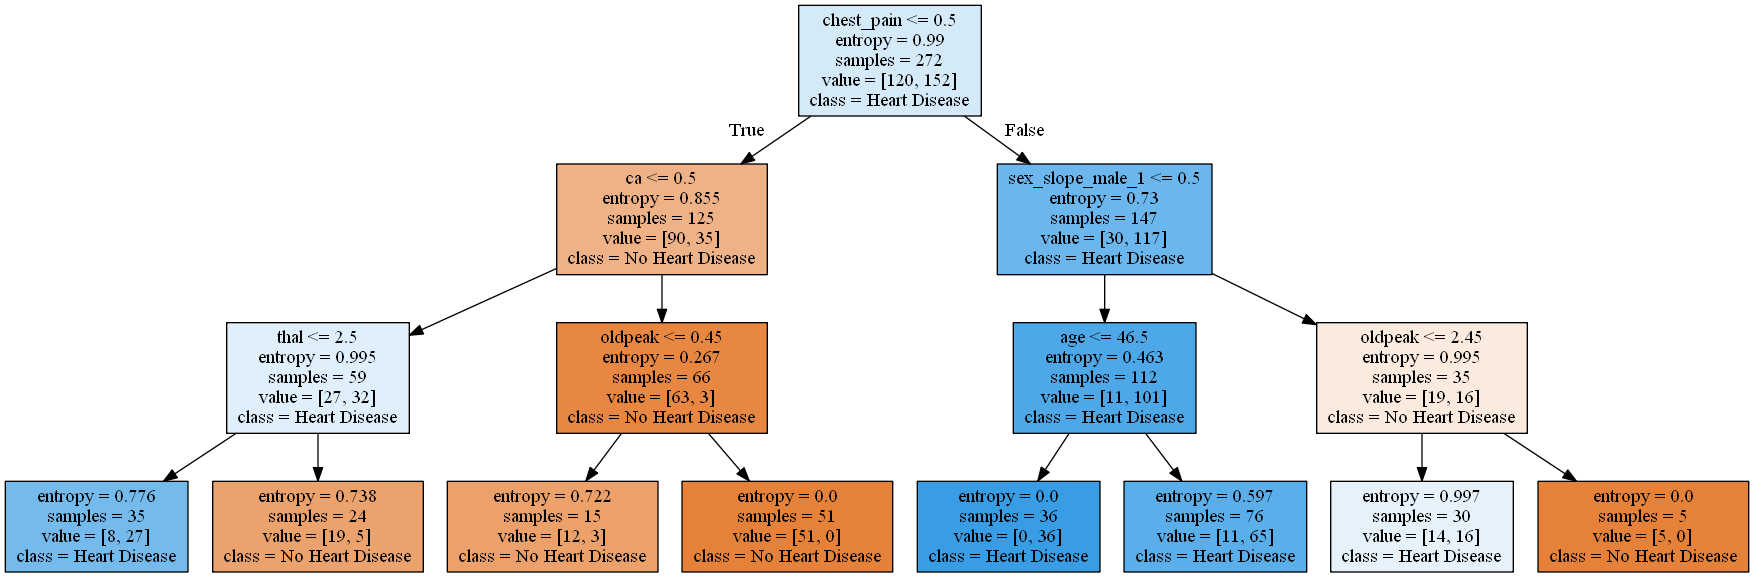

In [116]:
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    #max_features=5,
    max_depth=3,
)

start_time = time.time()
decision_tree.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))


dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['No Heart Disease', 'Heart Disease'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [117]:
decision_tree.score(X_test, y_test)

0.8064516129032258

In [8]:
classifiers = {'knn' : KNeighborsClassifier, 
               'forest' : ensemble.RandomForestClassifier,
               'logregr' : linear_model.LogisticRegression,
               'ridge' : linear_model.RidgeClassifier,
               'svc' : svm.SVC,
               'boosting' : ensemble.GradientBoostingClassifier
              }

clf_grid = {'knn' : {'n_neighbors' : [1, 5, 10, 25], 
                     'weights' : ['uniform', 'distance'],
                     'algorithm' : ['ball_tree', 'kd_tree', 'brute']},
            'forest' : {'n_estimators' : [100, 500, 1000],
                        'criterion' : ['gini', 'entropy'], 
                        'max_depth' : [2, 5, 10]},
            'logregr' : {'penalty' : ['l1', 'l2'], 
                         'tol' : [1e-3, 1e-4, 1e-5], 
                         'C' : [1, 1e-2, 1e-4], 
                         'solver' : ['liblinear']},
            'ridge' : {'alpha' : [1, 100, 1000], 
                       'tol' : [1e-3, 1e-4, 1e-5], 
                       'solver' : ['svd', 'cholesky', 'lsqr']}, #, ‘sparse_cg’, ‘sag’, ‘saga’,
            'svc' : {'C' : [1, 1e-2, 1e-3], 
                     'kernel' : ['linear', 'rbf'],  #, 'poly'
                     'gamma' : ['auto']},
            'boosting' : {'n_estimators': [100, 500, 1000],
                          'max_depth': [2, 3, 4],
                          'loss': ['deviance', 'exponential'],
                          'subsample' : [0.4, 0.8, 1]}
           }

In [20]:
def grid_search(X_train, X_test, y_train, y_test):
    results = pd.DataFrame()
    for method in classifiers.keys():
        classifier, parameters = classifiers[method](), clf_grid[method]
        for parameter_set in ParameterGrid(parameters):
            start_time = time.time()
            print('{} {}'.format(method, list(parameter_set.values())[:]))
            
            classifier.set_params(**parameter_set)
            classifier.fit(X_train, y_train.values.ravel())
            y_pred = classifier.predict(X_test)
            
            if (method == 'ridge') or (method == 'svc'):
                #d = classifier.decision_function(X_test)[0]
                #y_prob = np.exp(d) / np.sum(np.exp(d))
                Auroc = 0.5
            else:
                y_prob = classifier.predict_proba(X_test)[:,1] #More expensive
                Auroc = roc_auc_score(y_test, y_prob) #More expensive
                
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            Accuracy = accuracy_score(y_test, y_pred)
            Precision = precision_score(y_test, y_pred)
            Recall = recall_score(y_test, y_pred)
        
            df2 = pd.DataFrame([(method, parameter_set.values(), Accuracy, Precision, Recall, Auroc, fn, fp)], 
                           columns = ['Method' , 'Parameters', 'Accuracy', 'Precision' , 
                                      'Recall', 'Auroc', 'False negative', 'False positive'])
            results = results.append(df2, ignore_index=True)
            
            total_time = time.time() - start_time
            print('Done in {} seconds'.format(total_time))
        
    return results

In [21]:
results =  grid_search(X_train, X_test, y_train, y_test)

knn ['ball_tree', 1, 'uniform']
Done in 0.010991096496582031 seconds
knn ['ball_tree', 1, 'distance']
Done in 0.009962081909179688 seconds
knn ['ball_tree', 5, 'uniform']
Done in 0.011959075927734375 seconds
knn ['ball_tree', 5, 'distance']
Done in 0.00899505615234375 seconds
knn ['ball_tree', 10, 'uniform']
Done in 0.007979154586791992 seconds
knn ['ball_tree', 10, 'distance']
Done in 0.00898122787475586 seconds
knn ['ball_tree', 25, 'uniform']
Done in 0.00797891616821289 seconds
knn ['ball_tree', 25, 'distance']
Done in 0.008954048156738281 seconds
knn ['kd_tree', 1, 'uniform']
Done in 0.008952856063842773 seconds
knn ['kd_tree', 1, 'distance']
Done in 0.007010698318481445 seconds
knn ['kd_tree', 5, 'uniform']
Done in 0.007977008819580078 seconds
knn ['kd_tree', 5, 'distance']
Done in 0.006983280181884766 seconds
knn ['kd_tree', 10, 'uniform']
Done in 0.007975101470947266 seconds
knn ['kd_tree', 10, 'distance']
Done in 0.0079803466796875 seconds
knn ['kd_tree', 25, 'uniform']
Done in

C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



ridge [1, 'cholesky', 0.0001]
Done in 0.005984306335449219 seconds
ridge [1, 'cholesky', 1e-05]
Done in 0.01894855499267578 seconds
ridge [1, 'lsqr', 0.001]
Done in 0.007982730865478516 seconds
ridge [1, 'lsqr', 0.0001]
Done in 0.007975101470947266 seconds
ridge [1, 'lsqr', 1e-05]
Done in 0.008976221084594727 seconds
ridge [100, 'svd', 0.001]
Done in 0.00897526741027832 seconds
ridge [100, 'svd', 0.0001]
Done in 0.006982088088989258 seconds
ridge [100, 'svd', 1e-05]
Done in 0.0059833526611328125 seconds
ridge [100, 'cholesky', 0.001]
Done in 0.006982564926147461 seconds
ridge [100, 'cholesky', 0.0001]
Done in 0.00698089599609375 seconds
ridge [100, 'cholesky', 1e-05]
Done in 0.0059833526611328125 seconds
ridge [100, 'lsqr', 0.001]
Done in 0.007979869842529297 seconds
ridge [100, 'lsqr', 0.0001]
Done in 0.006981372833251953 seconds
ridge [100, 'lsqr', 1e-05]
Done in 0.007977962493896484 seconds
ridge [1000, 'svd', 0.001]
Done in 0.005983829498291016 seconds
ridge [1000, 'svd', 0.0001]


In [24]:
results.sort_values(by='Recall', ascending=False)

,Method,Parameters,Accuracy,Precision,Recall,Auroc,False negative,False positive
92,svc,"(0.001, auto, rbf)",0.677419,0.677419,1.000000,0.500000,0,10
90,svc,"(0.01, auto, rbf)",0.677419,0.677419,1.000000,0.500000,0,10
88,svc,"(1, auto, rbf)",0.677419,0.677419,1.000000,0.500000,0,10
73,ridge,"(100, cholesky, 0.0001)",0.903226,0.909091,0.952381,0.500000,1,2
35,forest,"(entropy, 2, 1000)",0.935484,0.952381,0.952381,0.985714,1,1
71,ridge,"(100, svd, 1e-05)",0.903226,0.909091,0.952381,0.500000,1,2
70,ridge,"(100, svd, 0.0001)",0.903226,0.909091,0.952381,0.500000,1,2
69,ridge,"(100, svd, 0.001)",0.903226,0.909091,0.952381,0.500000,1,2
30,forest,"(gini, 10, 100)",0.967742,1.000000,0.952381,1.000000,1,0
68,ridge,"(1, lsqr, 1e-05)",0.935484,0.952381,0.952381,0.500000,1,1


In [29]:
results.groupby('Method').mean()

,Accuracy,Precision,Recall,Auroc,False negative,False positive
Method,,,,,,
boosting,0.881720,0.959890,0.862434,0.954056,2.888889,0.777778
forest,0.933692,0.976539,0.925926,0.989683,1.555556,0.500000
knn,0.661290,0.743158,0.761905,0.582143,5.000000,5.500000
logregr,0.725806,0.715562,0.714286,0.803968,6.000000,2.500000
ridge,0.892473,0.898268,0.952381,0.500000,1.000000,2.333333
svc,0.763441,0.783479,0.944444,0.500000,1.166667,6.166667


In [31]:
best = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=10)

In [45]:
cross_val_score(best, X, y, cv=135, scoring='recall')

array([1. , 1. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.5, 0.5, 1. ,
       1. , 1. , 0.5, 1. , 1. , 1. , 1. , 1. , 0.5, 1. , 1. , 1. , 0.5,
       0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. , 1. , 1. ,
       1. , 0. , 1. , 1. , 0. , 1. , 1. , 1. , 1. , 0. , 1. , 1. , 1. ,
       0. , 1. , 0. , 1. , 1. , 1. , 0. , 1. , 1. , 1. , 1. , 0. , 1. ,
       1. , 1. , 1. , 1. , 1. , 0. , 1. , 1. , 1. , 0. , 1. , 1. , 0. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 0. , 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 0. , 1. , 0. , 1. , 1. , 1. , 1. , 1. , 0. , 1. ,
       1. , 1. , 1. , 1. , 1. ])

In [54]:
loo = LeaveOneOut()

In [83]:
results_2 = pd.DataFrame()
for train_index, test_index in loo.split(X):
    
    X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
    best.fit(X_train, y_train.values.ravel())
    y_pred = best.predict(X_test)
    #y_prob = best.predict_proba(X_test)[:,1] #More expensive
    
    #Auroc = roc_auc_score(y_test, y_prob) #More expensive
    #tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    Accuracy = accuracy_score(y_test, y_pred)
    #Precision = precision_score(y_test, y_pred)
    #Recall = recall_score(y_test, y_pred)

    df3 = pd.DataFrame([Accuracy], columns = ['Accuracy'])
    
    results_2 = results_2.append(df3, ignore_index=True)

In [87]:
results_2.Accuracy.value_counts()

1.0    248
0.0     55
Name: Accuracy, dtype: int64

In [119]:
results_scaled =  grid_search(X_train_scaled, X_test_scaled, y_train, y_test)

knn ['ball_tree', 1, 'uniform']
Done in 0.015957355499267578 seconds
knn ['ball_tree', 1, 'distance']
Done in 0.00899815559387207 seconds
knn ['ball_tree', 5, 'uniform']
Done in 0.01094818115234375 seconds
knn ['ball_tree', 5, 'distance']
Done in 0.00999140739440918 seconds
knn ['ball_tree', 10, 'uniform']
Done in 0.011949300765991211 seconds
knn ['ball_tree', 10, 'distance']
Done in 0.008976221084594727 seconds
knn ['ball_tree', 25, 'uniform']
Done in 0.007978677749633789 seconds
knn ['ball_tree', 25, 'distance']
Done in 0.008976459503173828 seconds
knn ['kd_tree', 1, 'uniform']
Done in 0.012964963912963867 seconds
knn ['kd_tree', 1, 'distance']
Done in 0.006981372833251953 seconds
knn ['kd_tree', 5, 'uniform']
Done in 0.006981372833251953 seconds
knn ['kd_tree', 5, 'distance']
Done in 0.0069806575775146484 seconds
knn ['kd_tree', 10, 'uniform']
Done in 0.006982564926147461 seconds
knn ['kd_tree', 10, 'distance']
Done in 0.007978439331054688 seconds
knn ['kd_tree', 25, 'uniform']
Done

C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Val\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMe

Done in 0.02593088150024414 seconds
ridge [1, 'cholesky', 0.0001]
Done in 0.010971307754516602 seconds
ridge [1, 'cholesky', 1e-05]
Done in 0.023935794830322266 seconds
ridge [1, 'lsqr', 0.001]
Done in 0.012966156005859375 seconds
ridge [1, 'lsqr', 0.0001]
Done in 0.009972333908081055 seconds
ridge [1, 'lsqr', 1e-05]
Done in 0.007978439331054688 seconds
ridge [100, 'svd', 0.001]
Done in 0.005983829498291016 seconds
ridge [100, 'svd', 0.0001]
Done in 0.00797891616821289 seconds
ridge [100, 'svd', 1e-05]
Done in 0.005983829498291016 seconds
ridge [100, 'cholesky', 0.001]
Done in 0.005984306335449219 seconds
ridge [100, 'cholesky', 0.0001]
Done in 0.005983829498291016 seconds
ridge [100, 'cholesky', 1e-05]
Done in 0.005983829498291016 seconds
ridge [100, 'lsqr', 0.001]
Done in 0.005984067916870117 seconds
ridge [100, 'lsqr', 0.0001]
Done in 0.0059871673583984375 seconds
ridge [100, 'lsqr', 1e-05]
Done in 0.006978034973144531 seconds
ridge [1000, 'svd', 0.001]
Done in 0.00598454475402832 s

In [121]:
results_scaled.sort_values(by='Auroc', ascending=False)

,Method,Parameters,Accuracy,Precision,Recall,Auroc,False negative,False positive
26,forest,"(gini, 2, 1000)",0.774194,0.687500,0.846154,0.884615,2,5
37,forest,"(entropy, 5, 500)",0.774194,0.714286,0.769231,0.884615,3,4
28,forest,"(gini, 5, 500)",0.774194,0.714286,0.769231,0.880342,3,4
32,forest,"(gini, 10, 1000)",0.774194,0.714286,0.769231,0.880342,3,4
34,forest,"(entropy, 2, 500)",0.741935,0.666667,0.769231,0.880342,3,5
51,logregr,"(0.01, l2, liblinear, 0.001)",0.741935,0.647059,0.846154,0.880342,2,6
41,forest,"(entropy, 10, 1000)",0.774194,0.714286,0.769231,0.880342,3,4
31,forest,"(gini, 10, 500)",0.774194,0.714286,0.769231,0.880342,3,4
21,knn,"(brute, 10, distance)",0.774194,0.687500,0.846154,0.880342,2,5
13,knn,"(kd_tree, 10, distance)",0.774194,0.687500,0.846154,0.880342,2,5
